<a href="https://colab.research.google.com/github/roninram/BigData_Colab/blob/main/BD_LifeCycleEx01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,701 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [6,388 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Ge

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

In [6]:
# 2. Get the Data (Downloading a CSV version for Spark compatibility)
!wget -q https://raw.githubusercontent.com/databricks/Spark-The-Definitive-Guide/master/data/retail-data/all/online-retail-dataset.csv
print("Environment Ready & Data Ingested into Local Storage (HDFS Simulation)")

Environment Ready & Data Ingested into Local Storage (HDFS Simulation)


In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc

# Initialize a Spark Session (The entry point for the cluster)
spark = SparkSession.builder.appName("BigDataRetailLab").getOrCreate()

# Read data. Spark does not actually load the data yet (Lazy Evaluation); it just maps it.
df = spark.read.csv("online-retail-dataset.csv", header=True, inferSchema=True)

# Print the Schema (Structure) to verify
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [8]:
# Filter out null customers and negative quantities
# Note: 'df' is immutable. We create a new transformation lineage 'clean_df'
clean_df = df.filter(col("CustomerID").isNotNull()) \
             .filter(col("Quantity") > 0)

# Check how many rows we have (This is an 'Action', so Spark finally runs the job)
print(f"Cleaned Row Count: {clean_df.count()}")

Cleaned Row Count: 397924


In [9]:
# Create a temporary view so we can write SQL against the data
clean_df.createOrReplaceTempView("retail_sales")

# Run a distributed SQL query
# We calculate total revenue (Quantity * UnitPrice)
aggregated_df = spark.sql("""
    SELECT Country,
           ROUND(SUM(Quantity * UnitPrice), 2) as TotalRevenue
    FROM retail_sales
    GROUP BY Country
    ORDER BY TotalRevenue DESC
""")

aggregated_df.show(5)

+--------------+------------+
|       Country|TotalRevenue|
+--------------+------------+
|United Kingdom|  7308391.55|
|   Netherlands|   285446.34|
|          EIRE|    265545.9|
|       Germany|   228867.14|
|        France|   209024.05|
+--------------+------------+
only showing top 5 rows


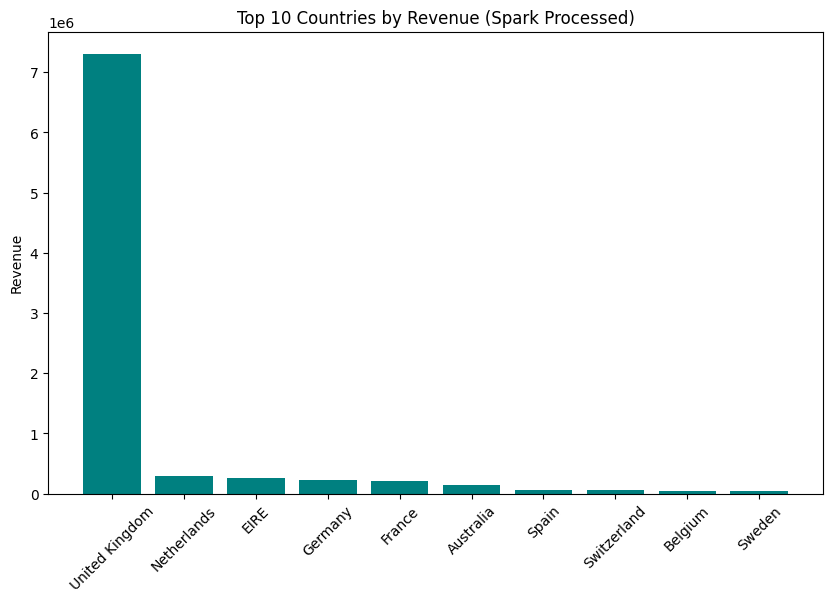

In [10]:
import matplotlib.pyplot as plt

# Collect results from the cluster to the 'driver' (local machine)
# WARNING: Only do this on aggregated data, never raw data!
pdf = aggregated_df.limit(10).toPandas()

# Visualize
plt.figure(figsize=(10,6))
plt.bar(pdf['Country'], pdf['TotalRevenue'], color='teal')
plt.title('Top 10 Countries by Revenue (Spark Processed)')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Save the aggregated results to a generic format (Parquet is standard for Big Data)
aggregated_df.write.mode("overwrite").parquet("revenue_report_2011")
print("Pipeline Complete: Data saved to Data Lake (Parquet format)")

Pipeline Complete: Data saved to Data Lake (Parquet format)


In [17]:
!wc -l online-retail-dataset.csv

541910 online-retail-dataset.csv
